In [1]:
%load_ext autoreload
%autoreload 2

# 1. Load Dataset

In [2]:
from hcmus.core import appconfig
from hcmus.lbs import LabelStudioConnector
from hcmus.data import LbsDataset

2025-04-12 16:43:40.779 | INFO     | hcmus.core.appconfig:<module>:7 - Load DotEnv: True
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
torch_device = "cpu"
lsb_connector = LabelStudioConnector(
    url=appconfig.LABEL_STUDIO_URL,
    api_key=appconfig.LABEL_STUDIO_API_KEY,
    project_id=appconfig.LABEL_STUDIO_PROJECT_MAPPING["validation"],
)
lsb_dataset = LbsDataset(lsb_connector, device=appconfig.TORCH_DEVICE, augmentation=False)
lsb_dataloader = lsb_dataset.get_dataloader()

Loading tasks:   1%|          | 1/100 [00:01<02:22,  1.44s/it]
2025-04-12 16:43:44.690 | INFO     | hcmus.data._lbs_dataset:__init__:33 - Number of labels: 16
2025-04-12 16:43:44.691 | INFO     | hcmus.data._lbs_dataset:__init__:34 - Number of data points: 7


In [6]:
from transformers import DetrForObjectDetection, DetrImageProcessor
import torch
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Load Hugging Face DETR model + processor
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")
model.eval()  # remove .cuda() if no GPU

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

In [7]:
def visualize_detr_hf_predictions(image_tensor, target, outputs, threshold=0.5, id2label=None):
    image = to_pil_image(image_tensor.cpu())
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)

    # Ground truth (green)
    for box in target["boxes"]:
        x1, y1, x2, y2 = box.cpu()
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)

    # Predictions (red)
    for score, label, box in zip(outputs["scores"], outputs["labels"], outputs["boxes"]):
        if score < threshold:
            continue
        x1, y1, x2, y2 = box.cpu()
        label_str = id2label[label.item()] if id2label else str(label.item())
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1, f'{label_str}: {score:.2f}', color='white',
                bbox=dict(facecolor='red', edgecolor='none', pad=1))
    plt.axis('off')
    plt.show()

def test_one_batch(dataloader, threshold=0.5):
    id2label = model.config.id2label
    for images, targets in dataloader:
        for i in range(len(images)):
            img_tensor = images[i]
            inputs = processor(images=to_pil_image(img_tensor), return_tensors="pt").to(model.device)

            with torch.no_grad():
                outputs = model(**inputs)

            # Convert outputs to COCO-style boxes in pixel space
            results = processor.post_process_object_detection(outputs, target_sizes=[img_tensor.shape[1:][::-1]])[0]

            visualize_detr_hf_predictions(img_tensor, targets[i], results, threshold, id2label)
        break


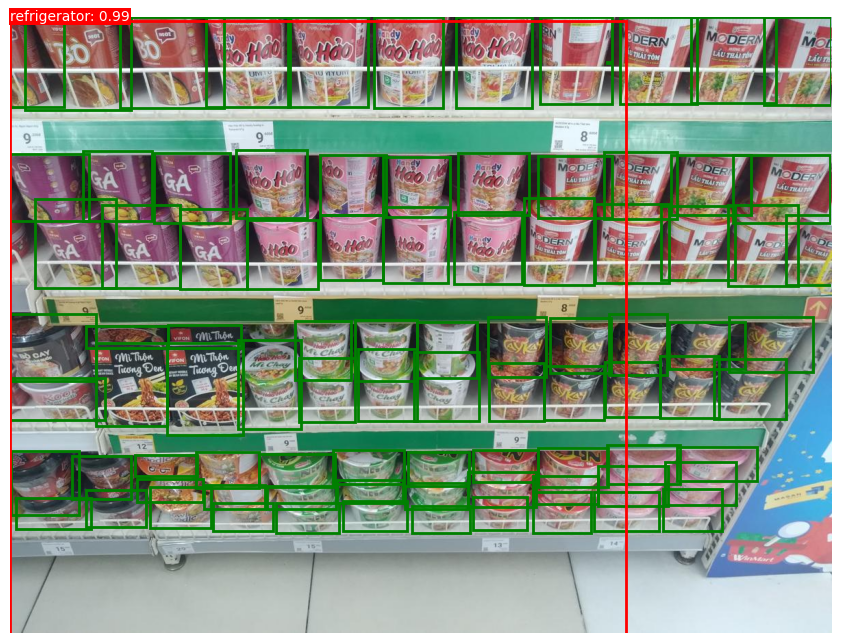

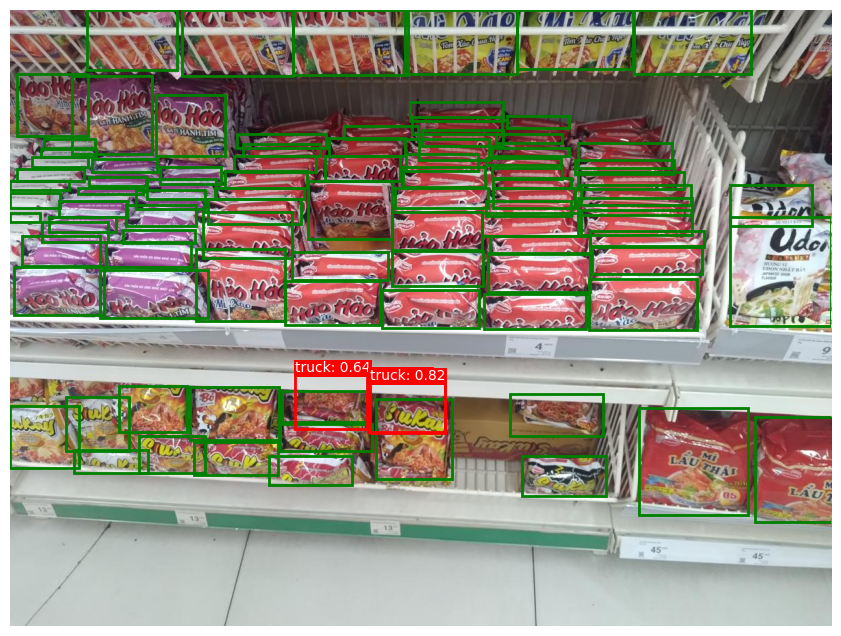

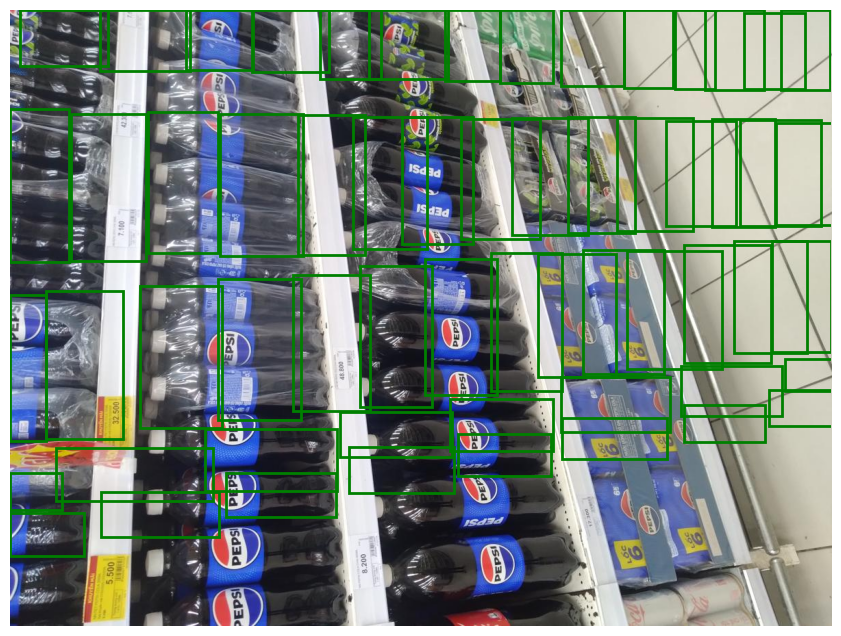

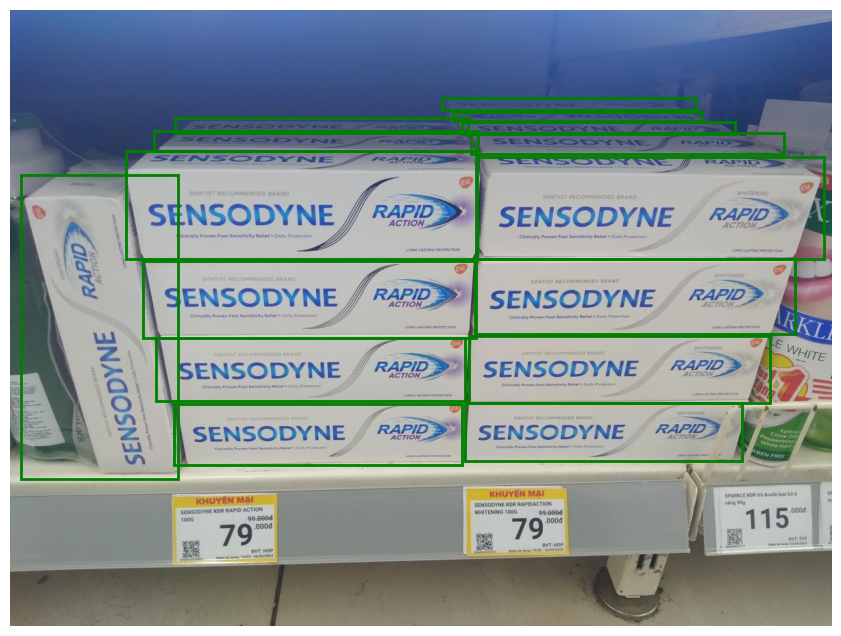

In [8]:
test_one_batch(lsb_dataloader, 0.1)